Accuracy: 28.57%


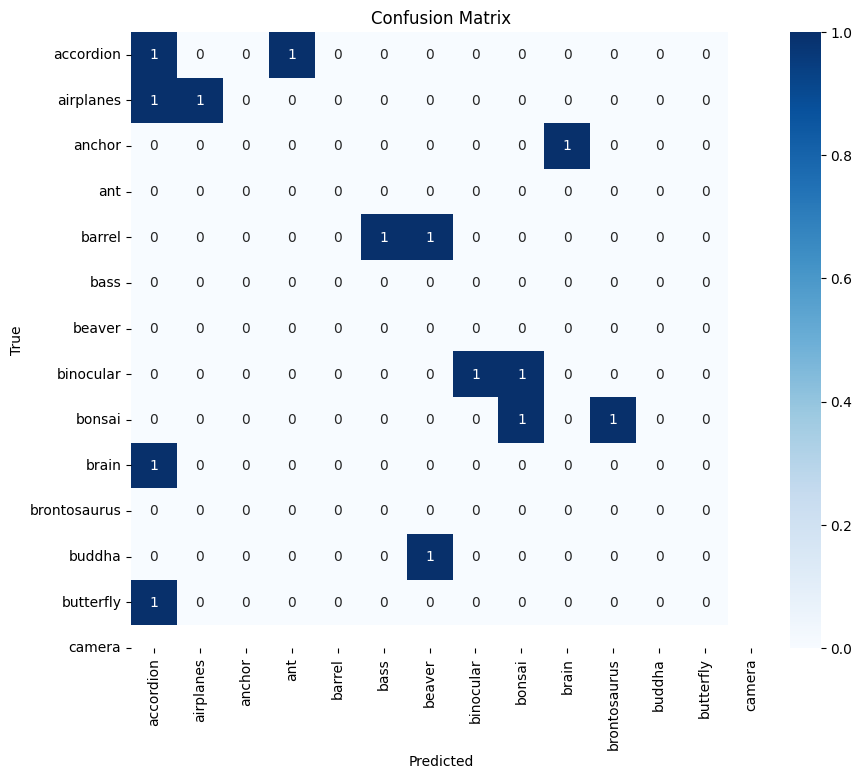

In [ ]:
import os
import numpy as np
import random
from skimage.io import imread
from skimage.color import rgb2lab, rgb2gray, gray2rgb
from skimage.transform import resize
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.feature_selection import SequentialFeatureSelector as SFS
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import cv2

# Extract the HW5_feature_selection.zip file
with zipfile.ZipFile('HW5_feature_selection.zip', 'r') as zip_ref:
    zip_ref.extractall()

# Define directories
train_dir = 'HWData/train'
test_dir = 'HWData/test'

# Function to process images and extract SIFT features using OpenCV
def process_images(directory, max_images_per_class=5):
    data = []
    labels = []
    paths = []

    for class_dir in os.listdir(directory):
        if class_dir in ['BACKGROUND_Google']:
            continue
        class_path = os.path.join(directory, class_dir)
        if os.path.isdir(class_path):
            img_files = os.listdir(class_path)
            random.shuffle(img_files)  # Shuffle the list of files to pick random samples
            img_count = 0
            for img_name in img_files:
                if img_count >= max_images_per_class:
                    break
                img_path = os.path.join(class_path, img_name)
                img = imread(img_path)

                # Ensure RGB format
                if len(img.shape) == 2:
                    img = gray2rgb(img)
                elif img.shape[2] == 4:
                    img = img[:, :, :3]

                img_resized = resize(img, (224, 224))  # Resize image to 224x224

                # Convert to LAB format
                img_lab = rgb2lab(img_resized)

                # Convert LAB image to grayscale for SIFT
                img_gray = rgb2gray(img_lab)  # Convert to grayscale

                # Extract SIFT features using OpenCV
                sift = cv2.SIFT_create()
                keypoints, descriptors = sift.detectAndCompute((img_gray * 255).astype(np.uint8), None)

                if descriptors is not None and descriptors.size > 0:
                    # Take the mean of the descriptors to create a fixed-size feature vector
                    mean_descriptor = np.mean(descriptors, axis=0)
                    data.append(mean_descriptor)
                    labels.append(class_dir)
                    paths.append(img_path)
                    img_count += 1

    return np.array(data), np.array(labels), paths

# Process training images
X, y, _ = process_images(train_dir, max_images_per_class=5)

# Feature selection: reduce the feature size by eliminating redundant ones
M = X.shape[1]
N = M // 2

sfs = SFS(SVC(kernel='linear'),
          n_features_to_select=N,
          direction='backward')

sfs.fit(X, y)
X_selected = sfs.transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

# Train the SVM classifier
svm_clf = SVC(kernel='linear', decision_function_shape='ovr')
svm_clf.fit(X_train, y_train)

# Predict the labels of the test set
y_pred = svm_clf.predict(X_test)

# Create confusion matrix and calculate accuracy
conf_matrix = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

# Print accuracy
print(f'Accuracy: {accuracy * 100:.2f}%')

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
